In [2]:
from src.utils import download_images

In [3]:
import pandas as pd
df = pd.read_csv('test.csv')

In [4]:
df_10 = df.sample(10)
df_10

,index,image_link,group_id,entity_name
6532,6542,https://m.media-amazon.com/images/I/41GtYB2jRD...,955292,item_weight
99912,99986,https://m.media-amazon.com/images/I/61BPivPI3f...,446789,height
68486,68547,https://m.media-amazon.com/images/I/51qImHNeod...,648011,depth
111155,111234,https://m.media-amazon.com/images/I/61bpowRw8J...,983323,wattage
53117,53164,https://m.media-amazon.com/images/I/51ZQIPSc0T...,900671,wattage
44037,44083,https://m.media-amazon.com/images/I/51PUTojPNl...,174276,depth
57475,57524,https://m.media-amazon.com/images/I/51eBJZ317U...,752266,height
21268,21295,https://m.media-amazon.com/images/I/510d3dri3y...,844474,height
6746,6756,https://m.media-amazon.com/images/I/41HhoVYbBl...,478357,width
123440,123532,https://m.media-amazon.com/images/I/71oDVByvM9...,529489,maximum_weight_recommendation


In [112]:
images_links = df_10['image_link'].to_list()

In [113]:
download_images(images_links, "./sample_images_1", True)

Exception in thread Thread-125 (_handle_workers):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\manas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\multiprocessing\pool.py", line 522, in _handle_workers
    cls._wait_for_updates(current_sentinels, change_notifier)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0

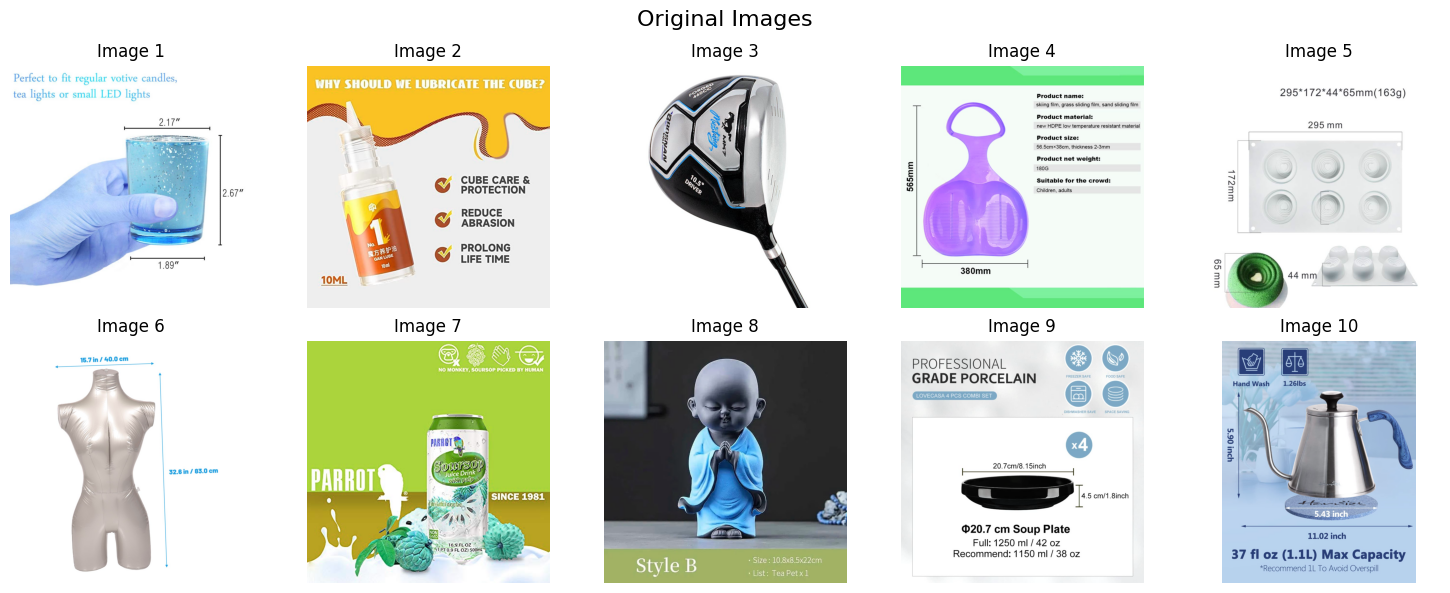

In [5]:
import cv2
import pytesseract
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to display multiple images in a grid
def display_images(images, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
    fig.suptitle(title, fontsize=16)
    
    for i, img in enumerate(images):
        ax = axes[i // 5, i % 5]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

# Initialize an array to store the images
image_paths = [os.path.join('sample_images_1', filename) for filename in os.listdir('sample_images_1') if filename.endswith(('.png', '.jpg', '.jpeg'))]

original_images = [cv2.imread(path) for path in image_paths if cv2.imread(path) is not None]

display_images(original_images, "Original Images")


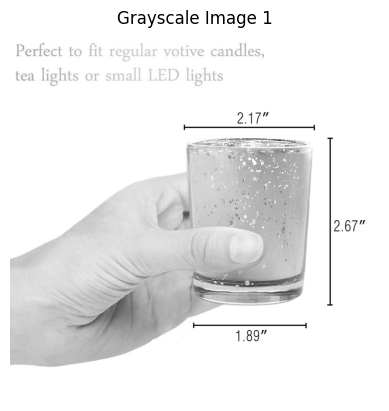

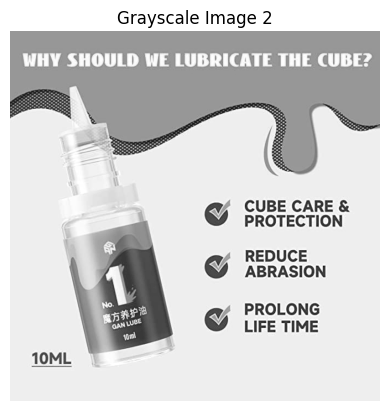

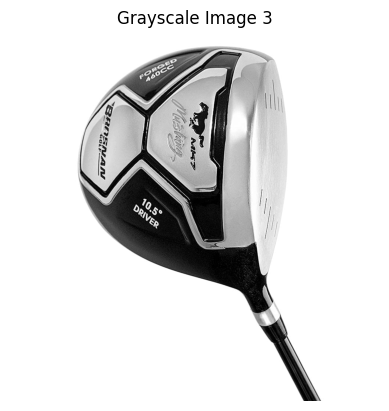

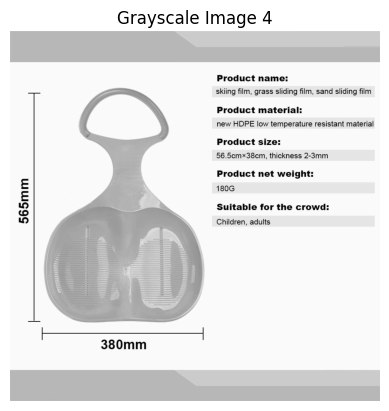

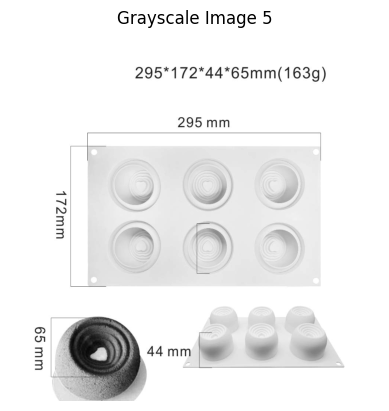

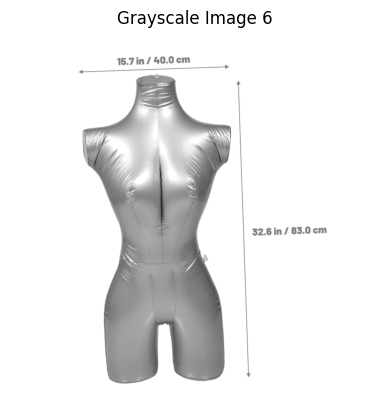

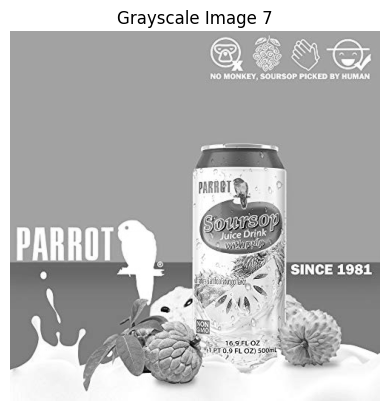

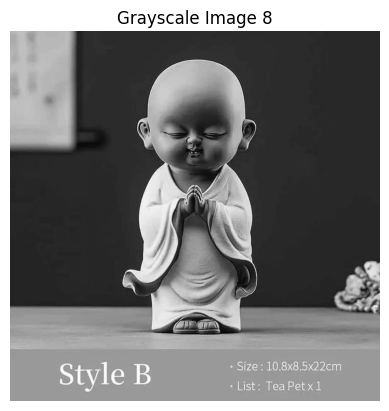

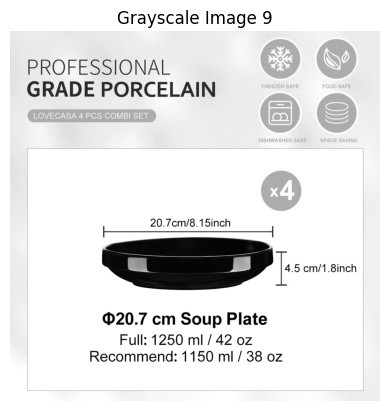

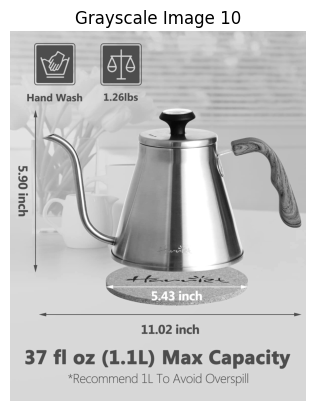

In [6]:
# Grayscale conversion
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in original_images]

# Display each grayscale image individually
for i, gray_img in enumerate(gray_images):
    plt.imshow(gray_img, cmap='gray')
    plt.title(f'Grayscale Image {i+1}')
    plt.axis('off')
    plt.show()


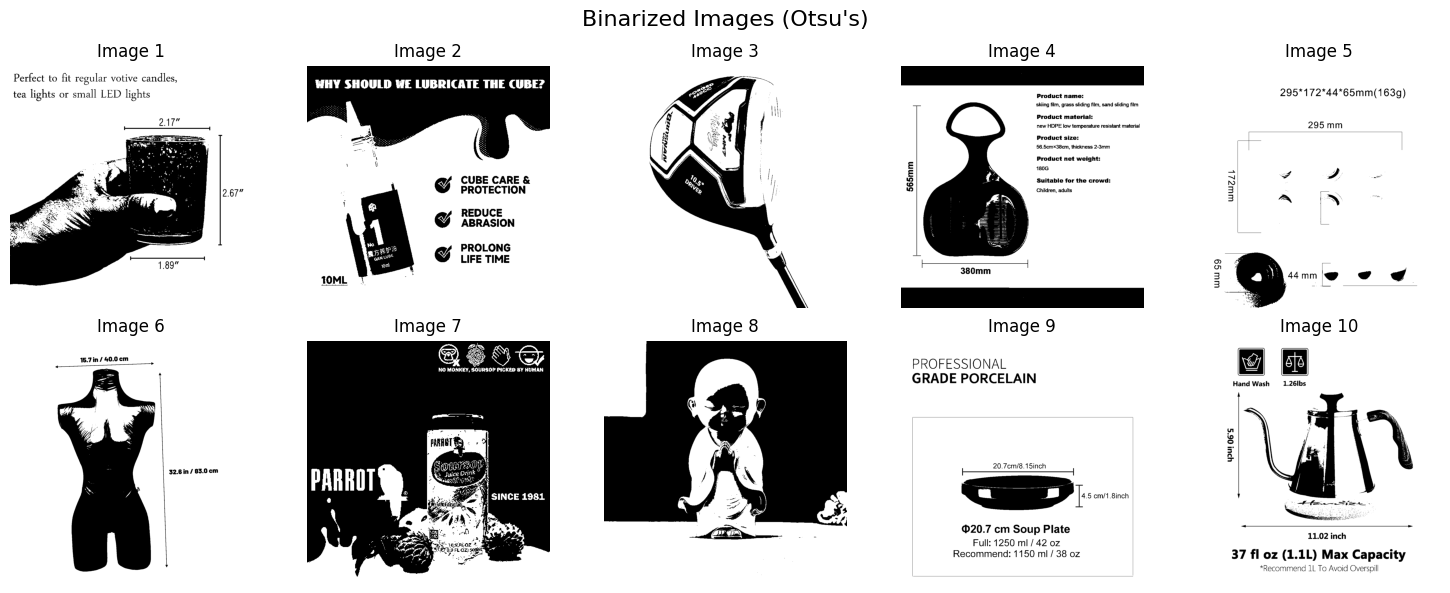

In [7]:
# Apply Otsu's binarization
binary_images = [cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] for img in original_images]
display_images(binary_images, "Binarized Images (Otsu's)")

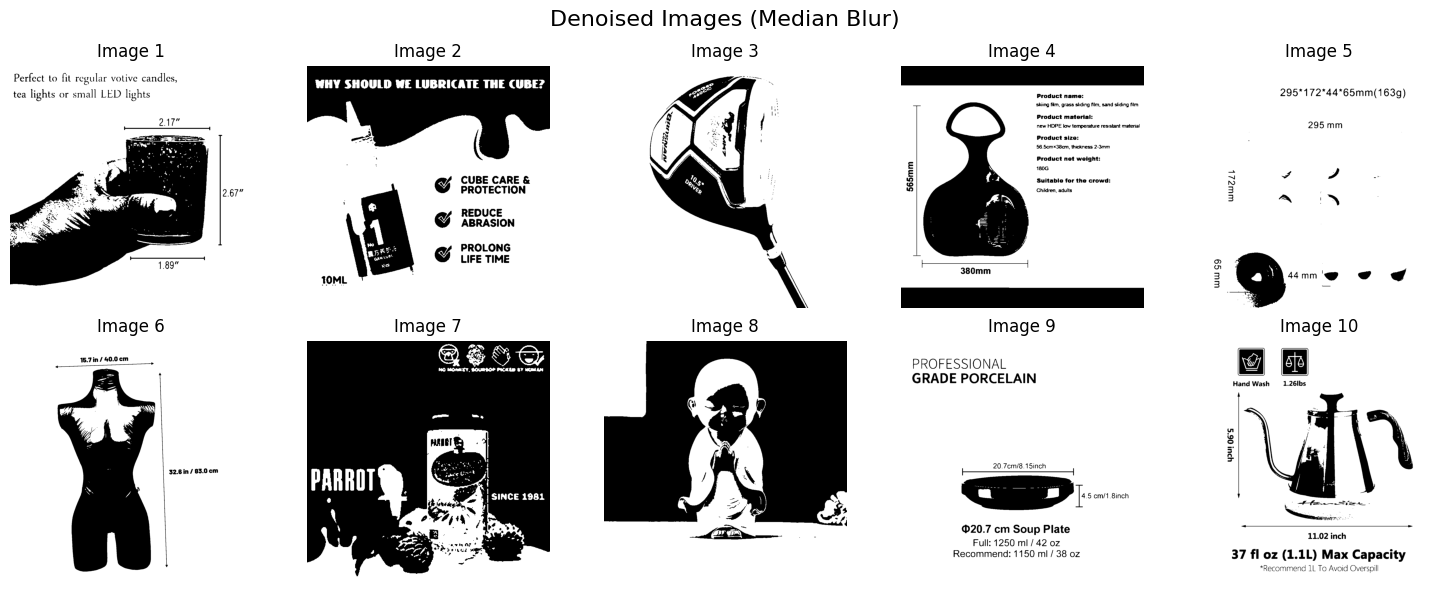

In [8]:
# 4. Noise removal using Median Blur and display
denoised_images = [cv2.medianBlur(binary, 3) for binary in binary_images]
display_images(denoised_images, "Denoised Images (Median Blur)")

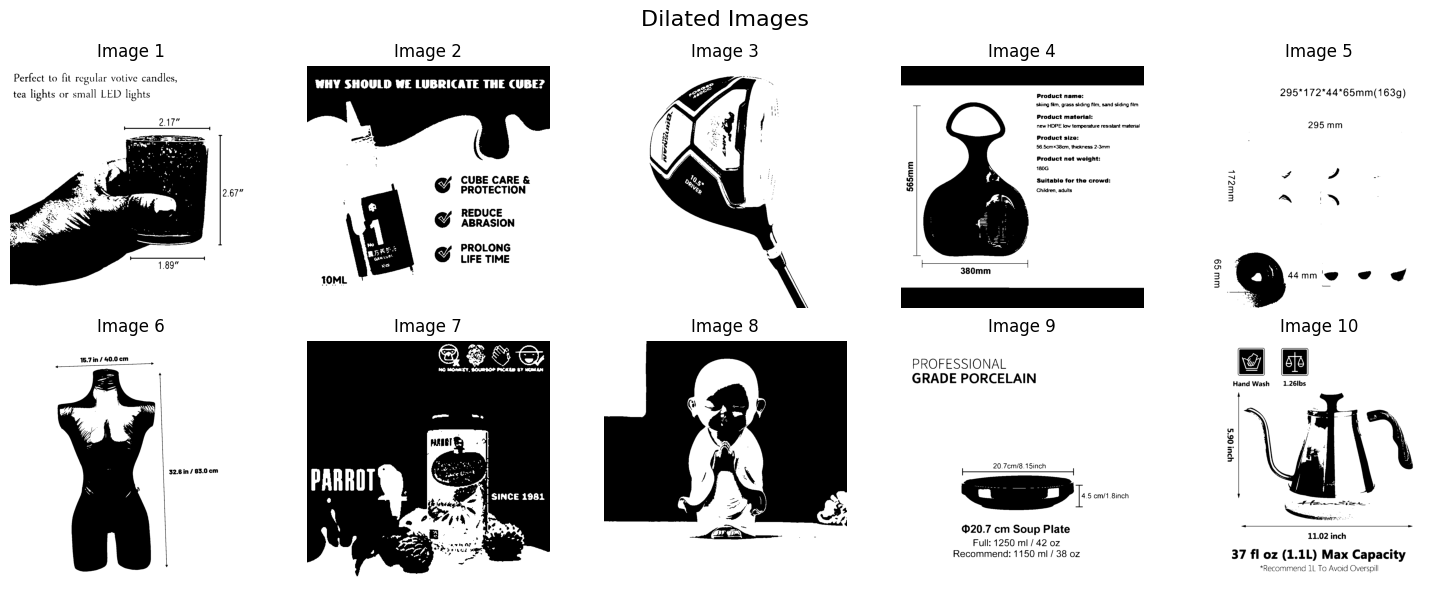

In [9]:
# 5. Dilation and display
kernel = np.ones((1, 1), np.uint8)
dilated_images = [cv2.dilate(denoised, kernel, iterations=1) for denoised in denoised_images]
display_images(dilated_images, "Dilated Images")

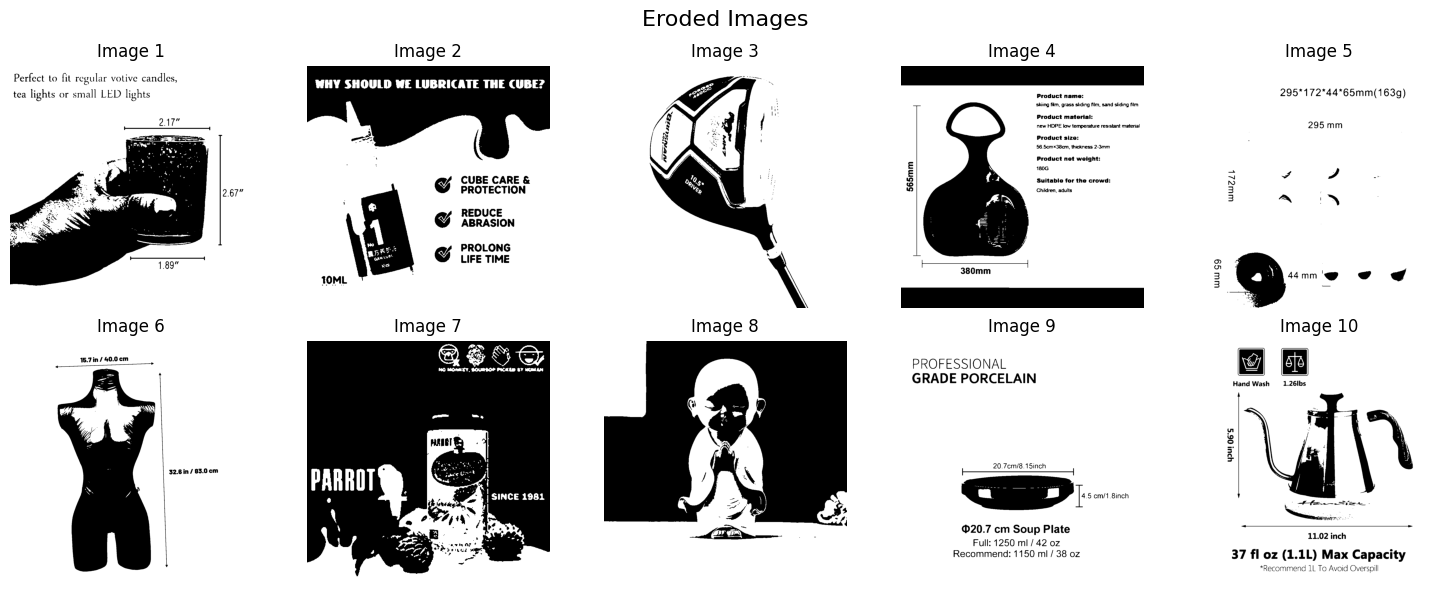

In [10]:
# 6. Erosion and display
eroded_images = [cv2.erode(dilated, kernel, iterations=1) for dilated in dilated_images]
display_images(eroded_images, "Eroded Images")


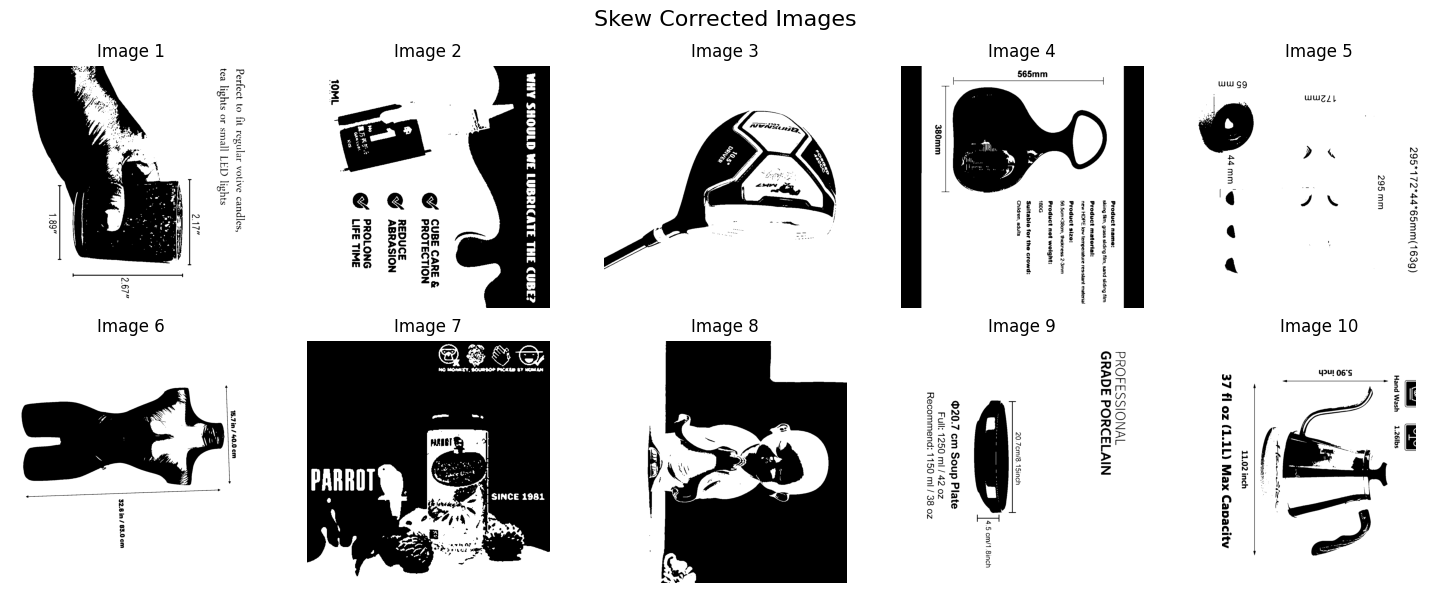

In [11]:
# 7. Skew Correction (rotation) and display
def correct_skew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated
skew_corrected_images = [correct_skew(eroded) for eroded in eroded_images]
display_images(skew_corrected_images, "Skew Corrected Images")

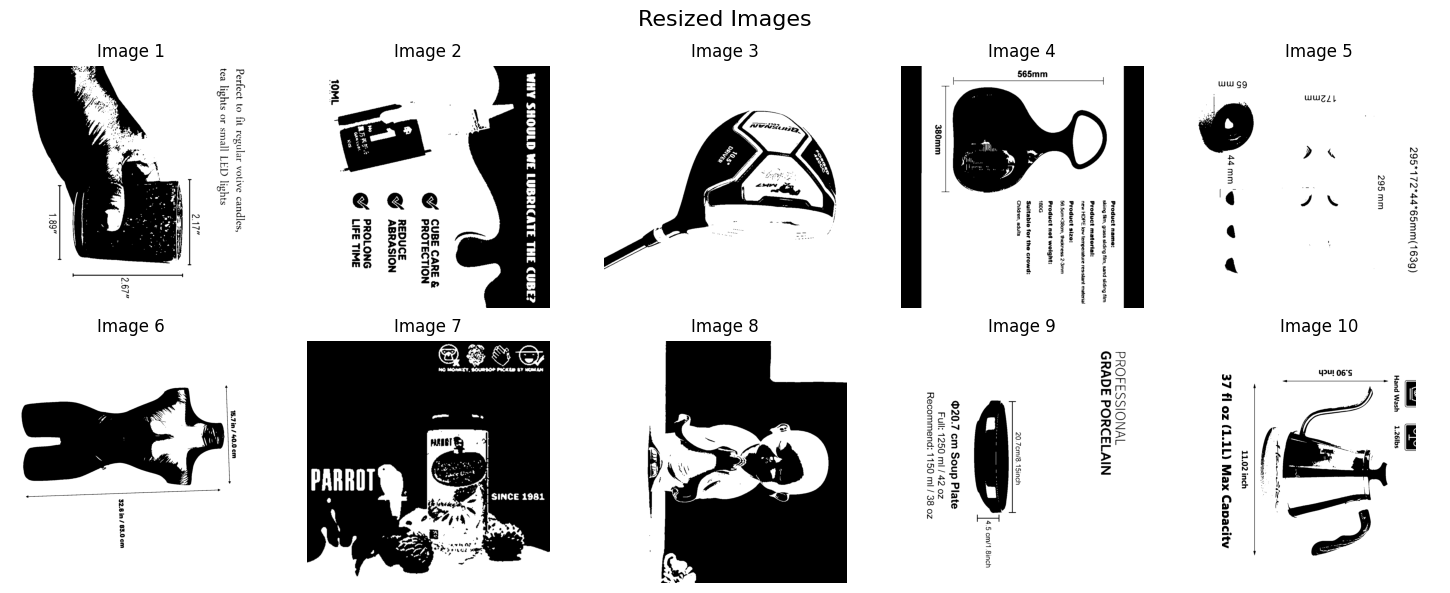

In [12]:
# 8. Resize images (increase size for better OCR performance)
resized_images = [cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC) for image in skew_corrected_images]
display_images(resized_images, "Resized Images")

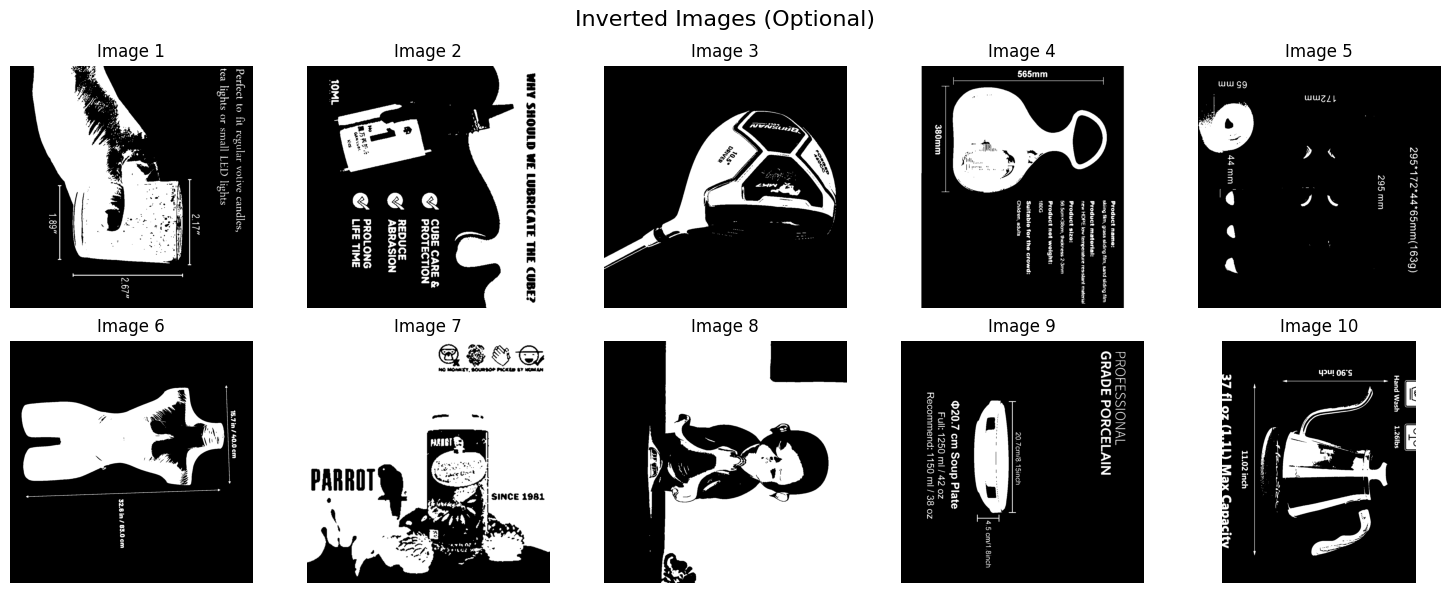

In [13]:
# 9. Invert colors for white text on black background (optional, based on image content)
inverted_images = [cv2.bitwise_not(image) for image in resized_images]
display_images(inverted_images, "Inverted Images (Optional)")

In [14]:
# 10. OCR Processing on each preprocessed image
ocr_results = []
for img in inverted_images:
    text = pytesseract.image_to_string(img)
    ocr_results.append(text)

In [15]:
# Output OCR results for each image
for idx, text in enumerate(ocr_results):
    print(f"Text from image {idx+1}:\n{text}\n")

Text from image 1:
Perfect to fit regular votive candles,

tea lights or small LED lights

2.67”



Text from image 2:
WHY SHOULD WE LUBRICATE THE CUBE?

Y CUBE CARE &
PROTECTION
REDUCE
/] ABRASION

PROLONG
] LIFE TIME



Text from image 3:


Text from image 4:
Product name:
skiing fim, grass sliding film, sand sliding film

Product material:

new HDPE kw temperature resistant maternal
Product size:

56 .5cemx38cm, thickness 2-3mm

Product net weight:

180G

Suitable for the crowd:

Children, adults

565mm



Text from image 5:
WW GQ

WW / |}

295*172*44*65mm(163g

295 mm

)



Text from image 6:
32.6 in / 83.0 cm



Text from image 7:


Text from image 8:


Text from image 9:
PROFESSIONAL
GRADE PORCELAIN

20.7cm/8.15inch

[és cm/1.8inch

©20.7 cm Soup Plate

Full: 1250 ml / 42 oz
Recommend: 1150 ml / 38 oz


Text from image 10:
Hand Wash 1.26lbs

Yu! 06°S

11.02 inch

37 fl oz (1.1L) Max Canacitv




In [17]:
import re
import string

def preprocess_ocr_text(ocr_results):
  
    
    # Remove unwanted characters (e.g. punctuation, special characters)
    ocr_results = re.sub(r'[^a-zA-Z0-9\s]', '', ocr_results)

    # Convert to lowercase
    # ocr_results = ocr_results.lower()

    # Remove extra whitespace
    ocr_results = re.sub(r'\s+', ' ', ocr_results)

    # Remove leading and trailing whitespace
    ocr_results = ocr_results.strip()

    return ocr_results

In [18]:
prep_text = []
for text in ocr_results:
  preprocessed_text = preprocess_ocr_text(text)
  prep_text.append(preprocessed_text)


In [19]:
print(prep_text)

['Perfect to fit regular votive candles tea lights or small LED lights 267', 'WHY SHOULD WE LUBRICATE THE CUBE Y CUBE CARE PROTECTION REDUCE ABRASION PROLONG LIFE TIME', '', 'Product name skiing fim grass sliding film sand sliding film Product material new HDPE kw temperature resistant maternal Product size 56 5cemx38cm thickness 23mm Product net weight 180G Suitable for the crowd Children adults 565mm', 'WW GQ WW 2951724465mm163g 295 mm', '326 in 830 cm', '', '', 'PROFESSIONAL GRADE PORCELAIN 207cm815inch s cm18inch 207 cm Soup Plate Full 1250 ml 42 oz Recommend 1150 ml 38 oz', 'Hand Wash 126lbs Yu 06S 1102 inch 37 fl oz 11L Max Canacitv']


In [20]:
for text in ocr_results:
    print(f" Text: {text}")

 Text: Perfect to fit regular votive candles,

tea lights or small LED lights

2.67”


 Text: WHY SHOULD WE LUBRICATE THE CUBE?

Y CUBE CARE &
PROTECTION
REDUCE
/] ABRASION

PROLONG
] LIFE TIME


 Text: 
 Text: Product name:
skiing fim, grass sliding film, sand sliding film

Product material:

new HDPE kw temperature resistant maternal
Product size:

56 .5cemx38cm, thickness 2-3mm

Product net weight:

180G

Suitable for the crowd:

Children, adults

565mm


 Text: WW GQ

WW / |}

295*172*44*65mm(163g

295 mm

)


 Text: 32.6 in / 83.0 cm


 Text: 
 Text: 
 Text: PROFESSIONAL
GRADE PORCELAIN

20.7cm/8.15inch

[és cm/1.8inch

©20.7 cm Soup Plate

Full: 1250 ml / 42 oz
Recommend: 1150 ml / 38 oz

 Text: Hand Wash 1.26lbs

Yu! 06°S

11.02 inch

37 fl oz (1.1L) Max Canacitv



In [24]:
import spacy

In [22]:
nlp = spacy.load('en_core_web_sm')

In [23]:
i=0;
for text in ocr_results:
    doc = nlp(text)
    for entity in doc.ents:
        if (entity.label_=="QUANTITY"):
            print(f" Entity: {entity.text}, Label: {entity.label_}")
         

        
    

 Entity: 56 .5cemx38cm, Label: QUANTITY
 Entity: 565mm, Label: QUANTITY
 Entity: 295 mm, Label: QUANTITY
 Entity: 83.0 cm, Label: QUANTITY
 Entity: 20.7 cm, Label: QUANTITY
 Entity: 1250 ml / 42, Label: QUANTITY
 Entity: 1150 ml / 38, Label: QUANTITY
 Entity: 11.02 inch, Label: QUANTITY
